In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings

# settings 
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
warnings.simplefilter(action='ignore', category=InterpolationWarning)
sns.set_theme()
plt.rcParams['figure.figsize'] = [8, 4.5]

def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''

    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''

    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results


def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

# Correcting for Stationarity in Time Series

In [2]:
import cpi
from datetime import date
import quandl
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
QUANDL_KEY = ''
quandl.ApiConfig.api_key = QUANDL_KEY

In [4]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD', start_date='2012-01-01', ebd_date='2023-12-31')
df.rename(columns={'Value':'price'}, inplace=True)
df = df.resample('M').last()

In [5]:
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (98, 1)


,price
Date,
2012-01-31,1656.12
2012-02-29,1742.62
2012-03-31,1673.77
2012-04-30,1650.07
2012-05-31,1585.50


1- Deflate the gold prices (to 2023-12-31 USD values) and plot the results

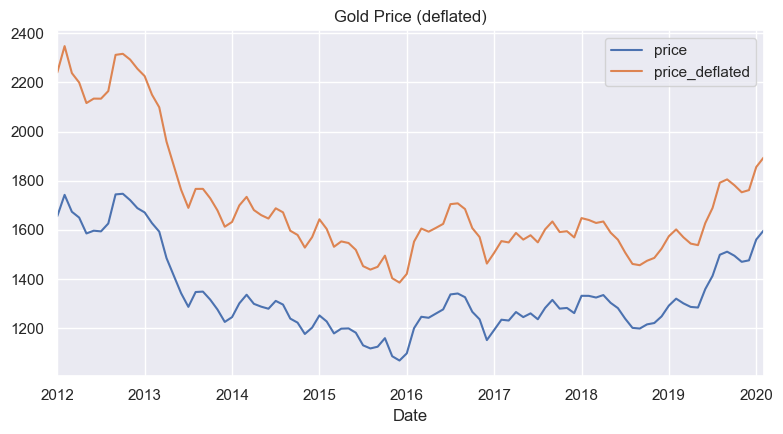

In [6]:
DEFL_DATE = date(2023, 12, 31)

df['dt_index'] = df.index.map(lambda x : x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x : cpi.inflate(x.price, x.dt_index, DEFL_DATE), axis=1)
df[['price', 'price_deflated']].plot(title='Gold Price (deflated)')

#show
plt.tight_layout()
plt.show()

2- Deflate the series using natural logarithm and plot it together with the rolling metrics

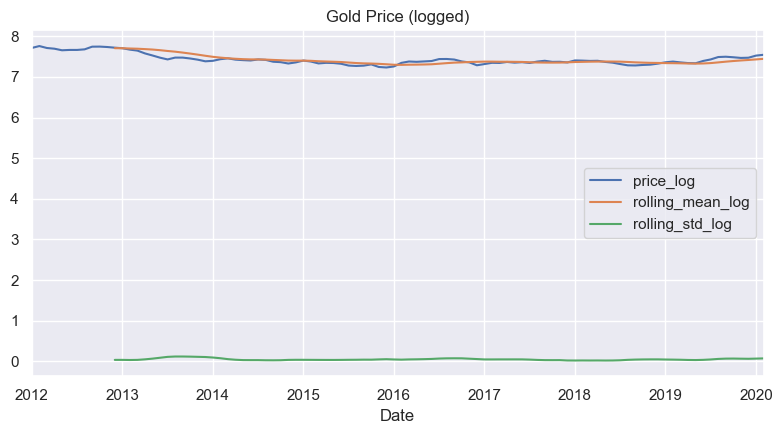

In [7]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW).mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW).std()
df[selected_columns].plot(title='Gold Price (logged)')

plt.tight_layout()
plt.show()

3- Use the 'test_autocorrelation' to invistigate if the series bacame stationary

ADF test statistic: -2.22 (p-val: 0.20)
KPSS test statistic: 0.81 (p-val: 0.01)


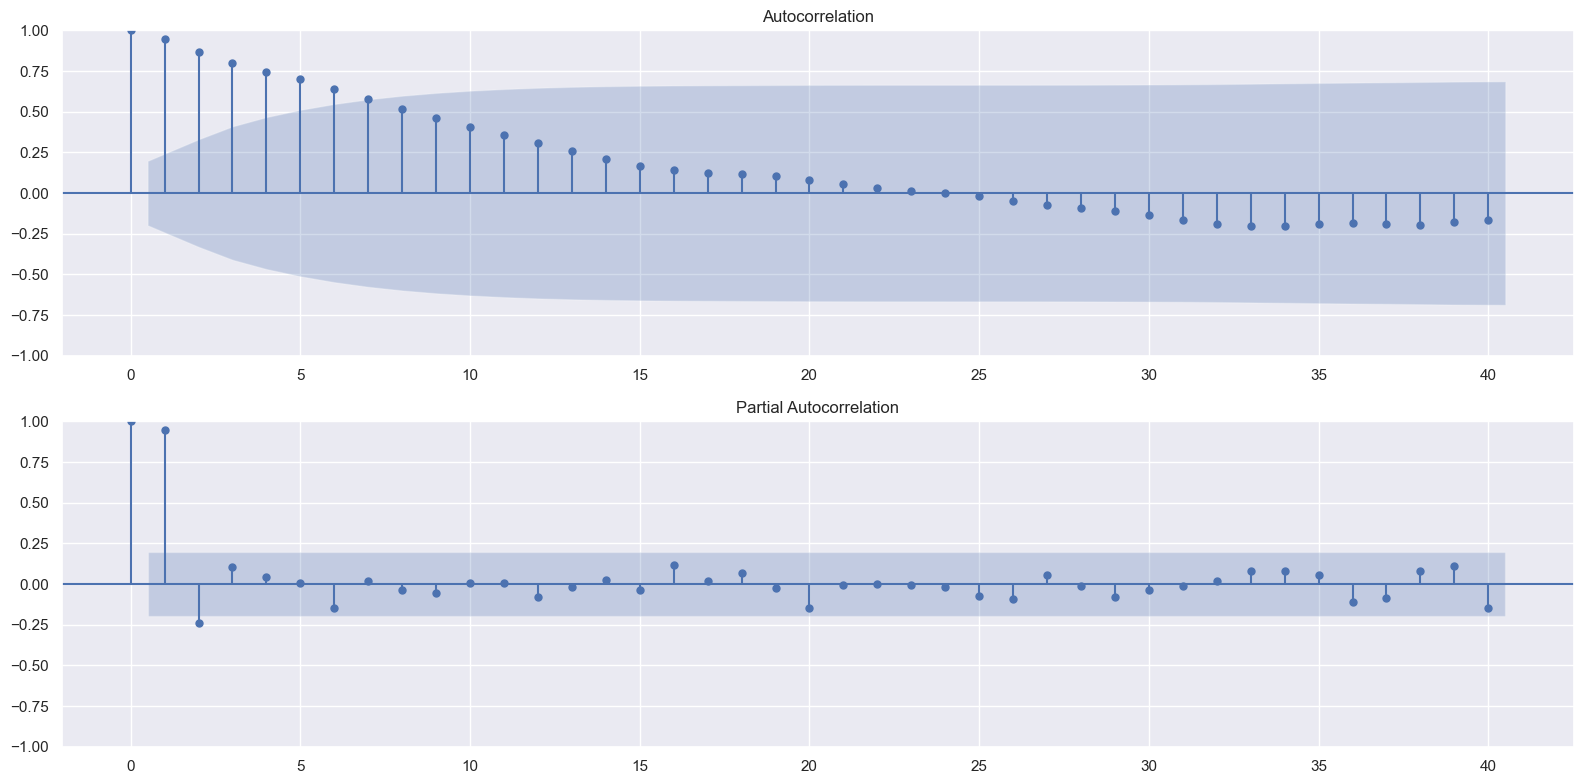

In [8]:
fig = test_autocorrelation(df.price_log)

plt.tight_layout()
plt.show()

4- Apply differencing to the series and plot the results

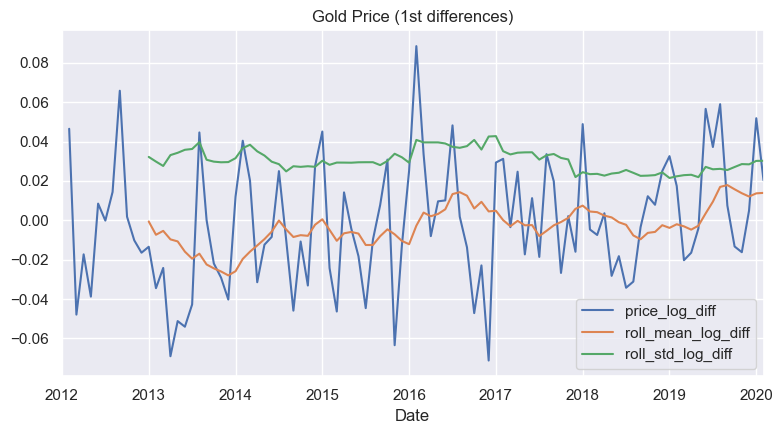

In [9]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW).mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW).std()
df[selected_columns].plot(title='Gold Price (1st differences)')

#show
plt.tight_layout()
plt.show()

5- Test if the series became stationary

ADF test statistic: -3.42 (p-val: 0.01)
KPSS test statistic: 0.39 (p-val: 0.08)


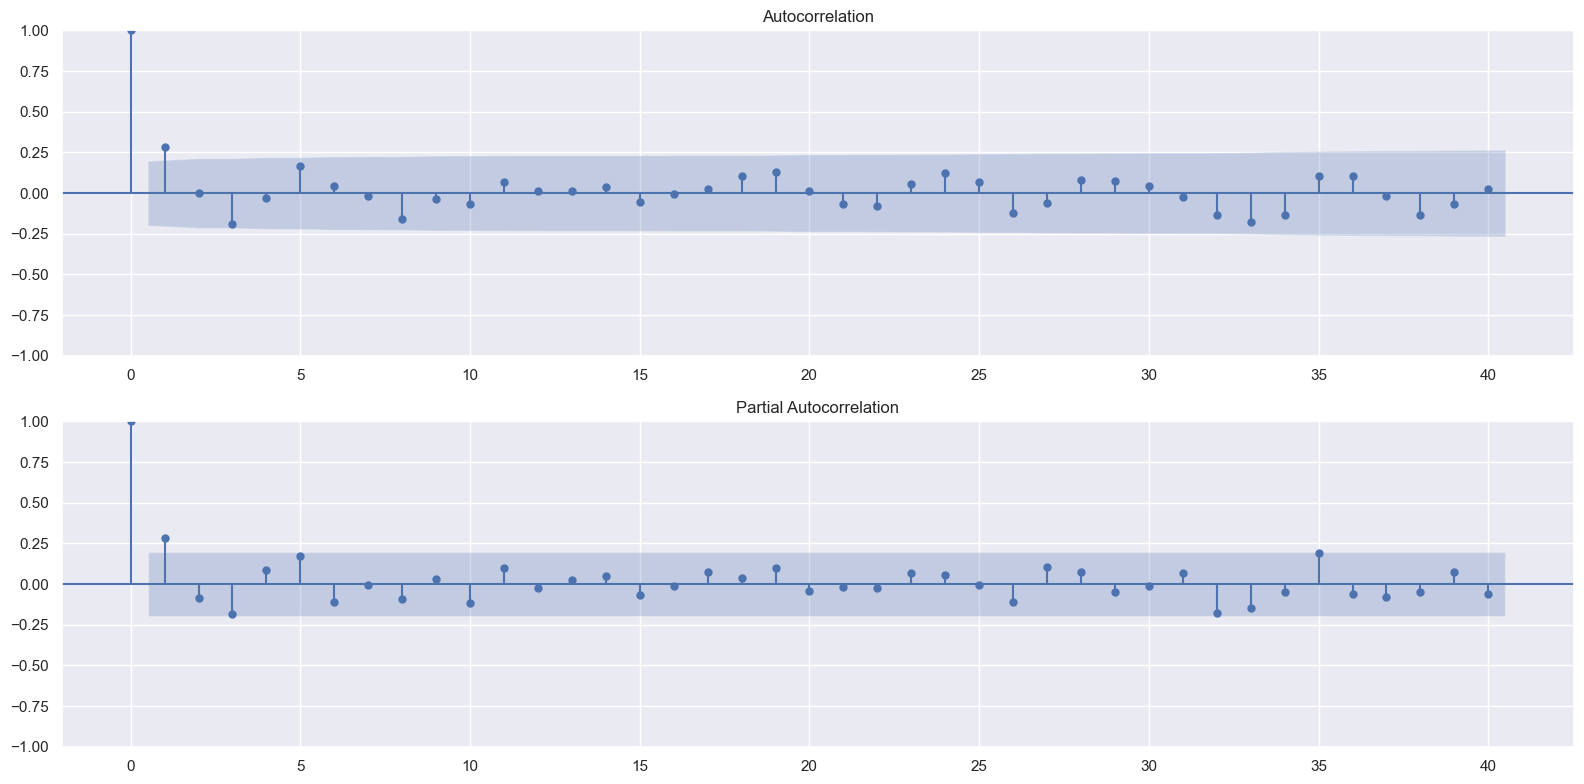

In [10]:
fig = test_autocorrelation(df.price_log_diff.dropna())

#show
plt.tight_layout()
plt.show()